In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q pymorphy2

In [0]:
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import joblib
import time
import os
import re
import json
from tqdm import tqdm_notebook
import gensim
import pymorphy2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score

In [0]:
matplotlib.rcParams['figure.figsize'] = (8, 8)
sns.set_style('whitegrid')

In [0]:
DIR_PATH = 'drive/My Drive/Colab Notebooks/Avito_catagory_classification'

Загрузка данных

In [0]:
dat = pd.read_csv(os.path.join(DIR_PATH, 'avito_train.csv'))
cat_descr = pd.read_csv(os.path.join(DIR_PATH, 'avito_category.csv'))
dat['category_name'] = dat.category_id.map(dict(zip(cat_descr.category_id, cat_descr.name)))

In [0]:
# cat_descr_dict = dict(cat_descr.values)

In [0]:
dat.head()

,item_id,title,description,price,category_id,category_name
0,0,Картина,Гобелен. Размеры 139х84см.,1000.0,19,Для дома и дачи|Мебель и интерьер|Предметы инт...
1,1,Стулья из прессованной кожи,Продам недорого 4 стула из светлой прессованно...,1250.0,22,Для дома и дачи|Мебель и интерьер|Столы и стулья
2,2,Домашняя мини баня,"Мини баня МБ-1(мини сауна), предназначена для ...",13000.0,37,Личные вещи|Красота и здоровье|Приборы и аксес...
3,3,"Эксклюзивная коллекция книг ""Трансаэро"" + подарок","Продам эксклюзивную коллекцию книг, выпущенную...",4000.0,43,Хобби и отдых|Книги и журналы|Книги
4,4,Ноутбук aser,Продаётся ноутбук ACER e5-511C2TA. Куплен в ко...,19000.0,1,Бытовая электроника|Ноутбуки


### Подготовка данных

Разобьём таргет на иерархические классы

In [0]:
# Длина самое длинной цепочти таргета
max_hierarchy_len = np.unique([len(cat_list.split('|')) for cat_list in dat.category_name.values])[-1]
dat['category_1'] = None
dat['category_2'] = None
dat['category_3'] = None
dat['category_4'] = None
splitted_categories = []
for i in tqdm_notebook(range(dat.shape[0])):
    split_categories = dat.category_name[i].split('|')
    splitted_categories.append(split_categories + [None for j in range(max_hierarchy_len - len(split_categories))])
dat[['category_1', 'category_2', 'category_3', 'category_4']] = splitted_categories
del splitted_categories

Загрузим список стоп-слов https://raw.githubusercontent.com/stopwords-iso/stopwords-ru/master/stopwords-ru.json

In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
stop_words_set = set(json.load(open(os.path.join(DIR_PATH, 'stopwords-ru.json'), mode='r', encoding='utf-8')))
stop_words_lemm_set = set()
for word in stop_words_set:
    lemm_word = morph.parse(word)[0].normal_form
    if lemm_word not in stop_words_lemm_set:
        stop_words_lemm_set = stop_words_lemm_set.union([lemm_word])
stop_words_lemm_set = stop_words_lemm_set.union(['продать', "купить", "скидка", "выгодно", "предложение", "подробность", 
                                                 "недорого", 'состояние', 'размер', "рубль", "отличный", "сантиметр", "цена", 
                                                "комплект", "мм", "см", "продавать", "торг", "доставка", "цвета", "звонить", "вес", 
                                                 "товар", 'любой', "продаваться", "качество", "продать"])
# Эти слова есть в названиях категорий
if "дом" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дом'])
if "книга" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['книга'])
if "другой" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['другой'])
if "дверь" in stop_words_lemm_set:
    stop_words_lemm_set = stop_words_lemm_set.difference(['дверь'])

Пример стоп-слов

In [0]:
print(list(stop_words_lemm_set)[:12])

['любой', 'мм', 'война', 'отсюда', 'спросить', 'тоже', 'увидеть', 'случай', 'человек', 'писать', 'таки', 'новый']


Лемматизируем категории

In [0]:
all_categories = dat.category_1.value_counts().keys().tolist() + \
dat.category_2.value_counts().keys().tolist() + \
dat.category_3.value_counts().keys().tolist() + \
dat.category_4.value_counts().keys().tolist()
cat_processed_cat_dict = {}
regexp_pattern = r'[_,.!><?"@#$%^&*\t():»«+-0123456789]'
for category in all_categories:
    sentence = re.sub(regexp_pattern, ' ', category.lower()).split()
    processed_category = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            processed_category += ' ' + lemm_word
    cat_processed_cat_dict[category] = processed_category.strip()
    
dat['category_1_processed'] = dat['category_1'].map(cat_processed_cat_dict)
dat['category_2_processed'] = dat['category_2'].map(cat_processed_cat_dict)
dat['category_3_processed'] = dat['category_3'].map(cat_processed_cat_dict)
dat['category_4_processed'] = dat['category_4'].map(cat_processed_cat_dict)

lemm_name = []
for full_category_name in tqdm_notebook(dat.category_name):
    current_lemm_name = ''
    for category in full_category_name.split('|'):
        current_lemm_name += cat_processed_cat_dict[category] + ' '
    lemm_name.append(current_lemm_name.strip())
dat['category_name_processed'] = lemm_name
del lemm_name

Лемматизируем тексты

In [0]:
dat['title_processed'] = None
dat['description_processed'] = None
title_processed_list = []
regexp_pattern = r'[_,.!><?"@#$%^&*\t():»«+-0123456789]'
for i in tqdm_notebook(range(len(dat))):
    sentence = re.sub(regexp_pattern, ' ', dat.title[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    title_processed_list.append(current_sentense.strip())
dat.title_processed = title_processed_list
del title_processed_list

description_processed_list = []
for i in tqdm_notebook(range(len(dat))):
    # убираем знаки препинания и пунктуацию
    sentence = re.sub(regexp_pattern, ' ', dat.description[i].lower()).split()
    current_sentense = ''
    for word in sentence:
        lemm_word = morph.parse(word)[0].normal_form
        if lemm_word not in stop_words_lemm_set:
            current_sentense += ' ' + lemm_word
    description_processed_list.append(current_sentense.strip())
dat.description_processed = description_processed_list
del description_processed_list
# Составим список всех предобработанных колонок
processed_columns = np.array([col for col in dat.columns if 'processed' in col or col == 'category_id'])


In [0]:
# # Сохраняем преобразованные тексты
# dat.to_csv(os.path.join(DIR_PATH, 'lemmatized_descriptions.csv'), index=False)

In [0]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tf_idf = TfidfVectorizer(min_df=20, max_df=0.90)
# cou = CountVectorizer(min_df=20, max_df=0.90)
tf_idf.fit(dat.description_processed)
# cou.fit(dat.description_processed)

In [0]:
word_idf_dict = dict(sorted(dict(zip(tf_idf.get_feature_names(), tf_idf.idf_)).items(), key=lambda x: x[1], reverse=False))
# Сохраним словарь слово-idf на диск
json.dump(word_idf_dict, open(os.path.join(DIR_PATH, 'word_idf_dict.json'), mode='w', encoding='utf-8'), indent=2, ensure_ascii=False)

Оставим в описаниях только слова из словарика tf_idf

In [0]:
sifted_description = []
for desc in tqdm_notebook(dat.description_processed):
    sifted_description.append(' '.join([word for word in desc.split() if word in tf_idf.vocabulary_]))
dat['description_processed'] = sifted_description
del sifted_description

Уберём тексты, где описание пустое

In [0]:
needed_texts = np.array([len(sentence) != 0 for sentence in dat['description_processed']])
print('Таких текстов: {}'.format((~needed_texts).sum()))

In [0]:
dat = dat.loc[needed_texts]
dat.index = range(dat.shape[0])
dat.title_processed = dat.title_processed.astype(str)
dat.description_processed = dat.description_processed.astype(str)
# Сохраняем преобразованные тексты
dat.to_csv(os.path.join(DIR_PATH, 'final_processed_texts.csv'), index=False)

In [0]:
# Загрузка данных
dat = pd.read_csv(os.path.join(DIR_PATH, 'final_processed_texts.csv'))
word_idf_dict = json.load(open(os.path.join(DIR_PATH, 'word_idf_dict.json'), mode='r', encoding='utf-8'))

Разбиение на обучение, валидацию и контроль

In [0]:
# tr_indexes, valid_indexes, te_indexes = np.split(np.arange(dat.shape[0]), [int(np.floor(0.6*dat.shape[0])), int(np.floor(0.6*dat.shape[0])) + 
#                           int(np.floor(0.3*dat.shape[0]))])
# np.save(os.path.join(DIR_PATH, 'train_indexes.npy'), tr_indexes)
# np.save(os.path.join(DIR_PATH, 'valid_indexes.npy'), valid_indexes)
# np.save(os.path.join(DIR_PATH, 'test_indexes.npy'), te_indexes)
tr_indexes = np.load(os.path.join(DIR_PATH, 'train_indexes.npy'))
valid_indexes = np.load(os.path.join(DIR_PATH, 'valid_indexes.npy'))
te_indexes = np.load(os.path.join(DIR_PATH, 'test_indexes.npy'))

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


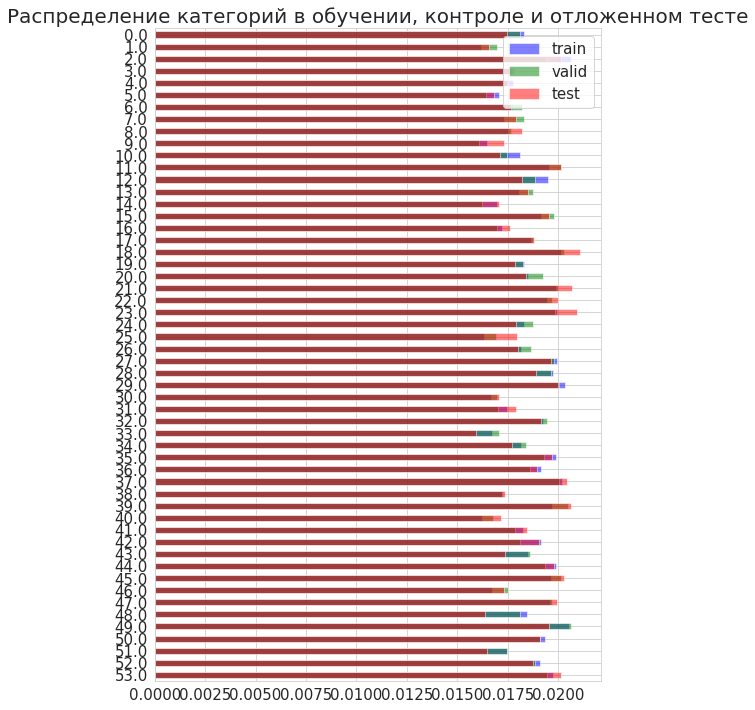

In [0]:
plt.figure(figsize=(8, 12))
plt.title('Распределение категорий в обучении, контроле и отложенном тесте', fontsize=20);
dat.category_id[tr_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='blue', alpha=0.5, label='train');
dat.category_id[valid_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='green', alpha=0.5, label='valid');
dat.category_id[te_indexes].value_counts(1).sort_index(ascending=False).plot(kind='barh', fontsize=15, color='red', alpha=0.5, label='test');
plt.legend(fontsize=15);

Посмотрим на распределение меток по уровням в обучении, контроле и отложенном тесте

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


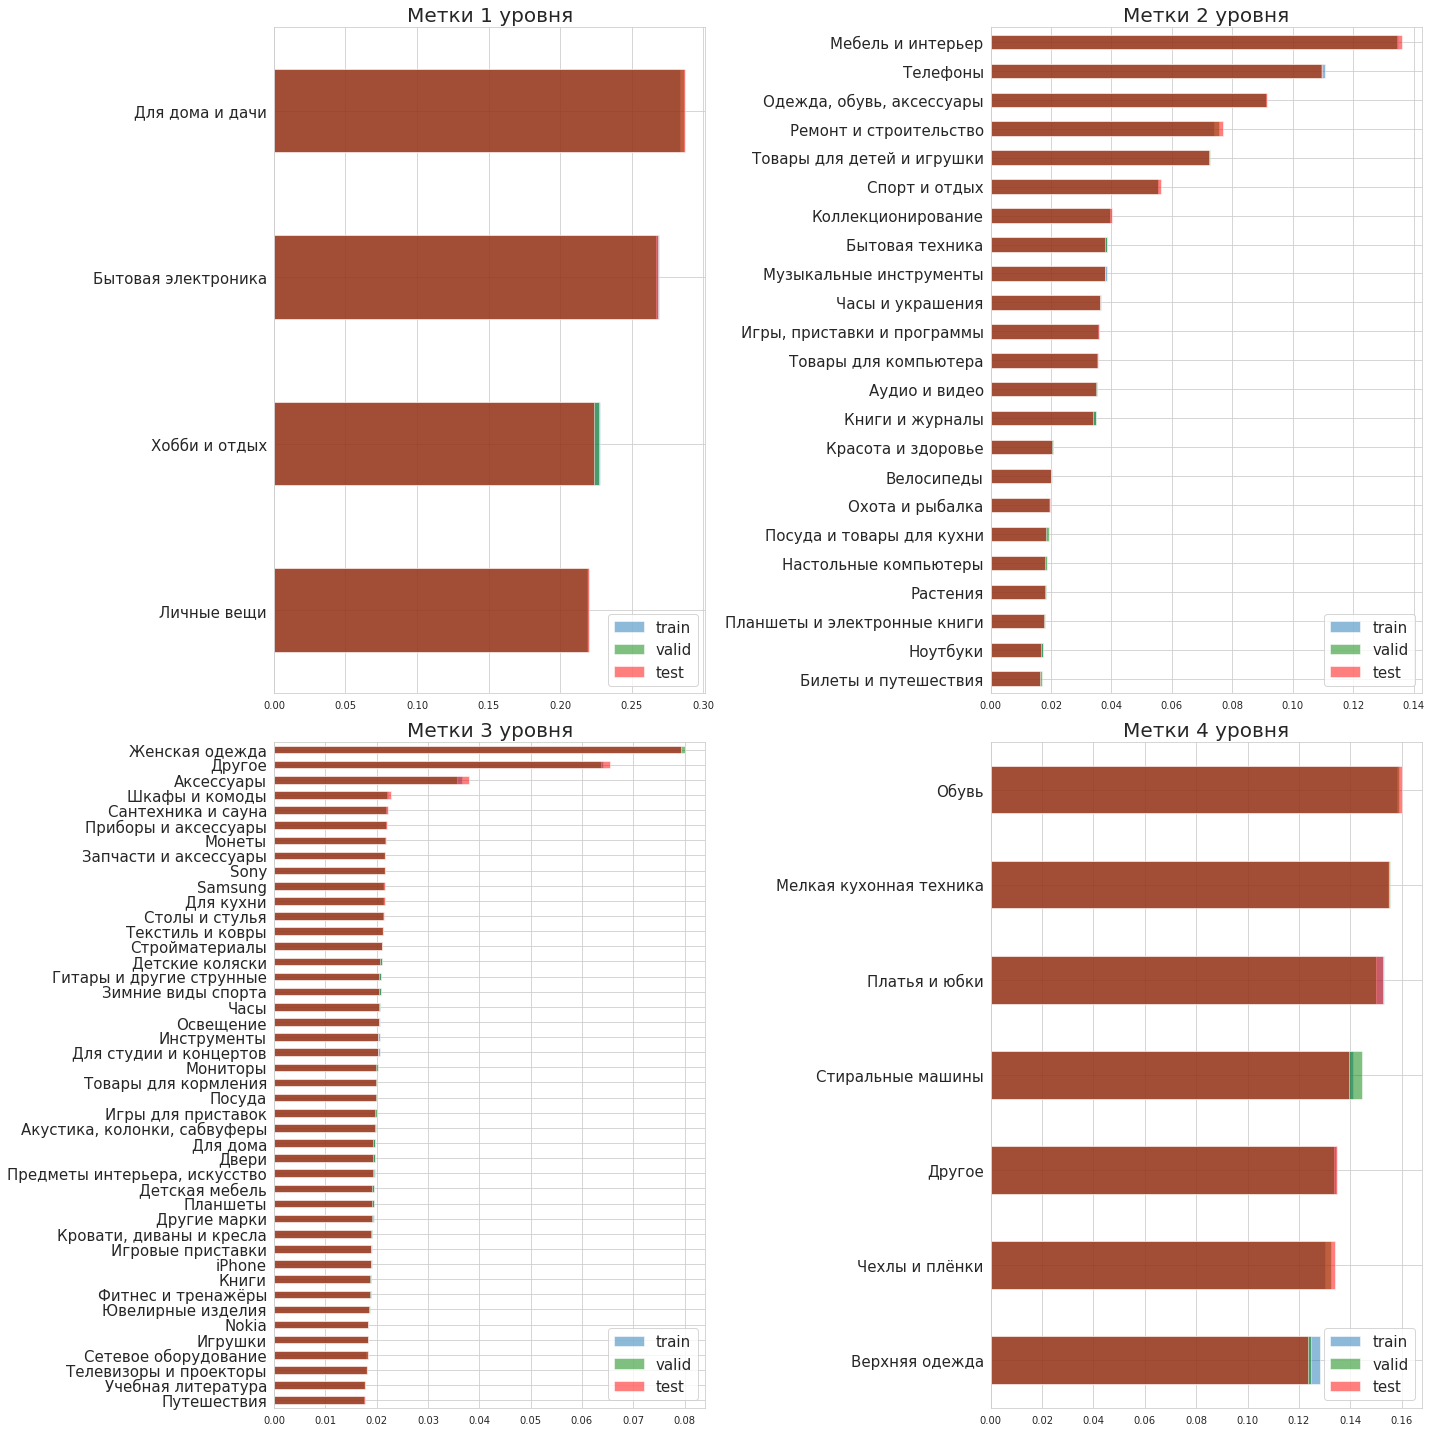

In [0]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
k = 1
for (i, j) in itertools.product(range(2), range(2)):
    dat['category_{}'.format(k)][tr_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', alpha=0.5, label='train', 
                                                                                              ax=ax[i, j])
    dat['category_{}'.format(k)][valid_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='green', alpha=0.5, 
                                                                                                 label='valid', ax=ax[i, j])
    dat['category_{}'.format(k)][te_indexes].value_counts(1).sort_values(ascending=True).plot(kind='barh', color='red', alpha=0.5, 
                                                                                              label='test', ax=ax[i, j])
    plt.sca(ax[i, j])
    plt.yticks(fontsize=15);
    plt.legend(fontsize=15);
    plt.title('Метки {} уровня'.format(k), fontsize=20);
    fig.tight_layout();
    k += 1

### Модели

Загружаем предобученный w2v на русской википедии https://nlpub.mipt.ru/Russian_Distributional_Thesaurus

In [0]:
%%time
w2v_fpath = os.path.join(DIR_PATH, 'tenth.norm-sz500-w7-cb0-it5-min5.w2v')
w2v = gensim.models.KeyedVectors.load_word2vec_format(w2v_fpath, binary=True, unicode_errors='ignore')
w2v.init_sims(replace=True)

Wall time: 3min 15s


Для каждого заголовка, для каждого описания и для каждой категории составим word2vec представление, взвешенное по idf

In [0]:
titles_w2v = np.zeros((dat.shape[0], 500))
descr_w2v = np.zeros((dat.shape[0], 500))
cat_w2v = np.zeros((dat.category_name_processed.value_counts().shape[0], 500))
category_names_order = dat.category_name_processed.value_counts().keys().values
for i in tqdm_notebook(range(dat.shape[0])):
    title = str(dat.title_processed[i]).split()
    descr = str(dat.description_processed[i]).split()
    
    denominator = np.array([word_idf_dict.get(word, 0) for word in title])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((500,)).astype(float) for word in title])
    titles_w2v[i] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)
    
    denominator = np.array([word_idf_dict.get(word, 0) for word in descr])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((500,)).astype(float) for word in descr])
    descr_w2v[i] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)
    
for n, categ in enumerate(category_names_order):
    denominator = np.array([word_idf_dict.get(word, 0) for word in str(categ).split()])
    numerator = np.array([w2v[word]*word_idf_dict.get(word, 0) if word in w2v else np.zeros((500,)).astype(float) for word in str(categ).split()])
    cat_w2v[n] = numerator.sum(axis=0)/(denominator.sum() + 1e-120)

C:\Users\anton.andreytsev\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [0]:
%%time
print('Начали считать title_cat_dist')
title_cat_dist = scipy.spatial.distance.cdist(titles_w2v, cat_w2v, metric='cosine')
print('Посчитали title_cat_dist')
title_descr_dist = []
for i in tqdm_notebook(range(len(dat))):
    dis = scipy.spatial.distance.cosine(titles_w2v[i].astype(float), descr_w2v[i].astype(float))
    if not np.isnan(dis):
        title_descr_dist.append(dis)
    else:
        title_descr_dist.append(-9999.0)
print('Начали считать descr_cat_dist')
descr_cat_dist = scipy.spatial.distance.cdist(descr_w2v, cat_w2v, metric='cosine')
print('Посчитали descr_cat_dist')

Начали считать title_cat_dist
Посчитали title_cat_dist


C:\Users\anton.andreytsev\Anaconda3\lib\site-packages\scipy\spatial\distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)



Начали считать descr_cat_dist
Посчитали descr_cat_dist
Wall time: 1min 43s


Матрица фичей - конкатенация расстояний

In [0]:
X = np.hstack((title_cat_dist, np.array(title_descr_dist).reshape(-1, 1), descr_cat_dist))
y = dat.category_id.values
tr_nonnull = tr_indexes[~np.isnan(X[tr_indexes].sum(axis=1))]
te_nonnull = te_indexes[~np.isnan(X[te_indexes].sum(axis=1))]
valid_nonnull = valid_indexes[~np.isnan(X[valid_indexes].sum(axis=1))]
X_tr = X[tr_nonnull]
y_tr = y[tr_nonnull]
X_te = X[np.union1d(te_nonnull, valid_nonnull)]
y_te = y[np.union1d(te_nonnull, valid_nonnull)]
X_valid = X[valid_nonnull]
y_valid = y[valid_nonnull]

#### Бейзлайн

In [0]:
from sklearn.linear_model import LogisticRegression

В качестве бейзлайна обучим логистическую регрессию, чтобы оценить, насколько лучше более сложные модели работают

In [0]:
%%time
model = LogisticRegression(C=5, multi_class='auto')
model.fit(X_tr, y_tr)

C:\Users\anton.andreytsev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Wall time: 41min 11s


LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
# Качество на отложенном тесте
accuracy_score(y_true=y_te, y_pred=model.predict(X_te))

0.7313647879252074

In [0]:
from lightgbm import LGBMClassifier

In [0]:
%%time
model_lgb = LGBMClassifier(n_estimators=100)
model_lgb.fit(X_tr, y_tr)

Wall time: 4min 11s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [0]:
# Качество на отложенном тесте
accuracy_score(y_true=y_te, y_pred=model_lgb.predict(X_te))

0.7440212530061113

#### Нейронки

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

Начнём с простой модели: Tfidf(title + description) + расстояния между описаниями -> полносвязная сетка

In [0]:
dat.title_processed = (dat.title_processed).astype(str)

In [0]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_descr = TfidfVectorizer(min_df=20, max_df=0.9)
tf_idf_descr.fit(dat.description_processed[tr_indexes])
tf_idf_descr_tr = tf_idf_descr.transform(dat.description_processed[tr_indexes])

tf_idf_title = TfidfVectorizer(min_df=15, max_df=0.95)
tf_idf_title.fit(dat.title_processed[tr_indexes])
tf_idf_title_tr = tf_idf_title.transform(dat.title_processed[tr_indexes])

tf_idf_title_valid = tf_idf_title.transform(dat.title_processed[valid_indexes])
tf_idf_descr_valid = tf_idf_descr.transform(dat.description_processed[valid_indexes])

tf_idf_title_test = tf_idf_title.transform(dat.title_processed[te_indexes])
tf_idf_descr_test = tf_idf_descr.transform(dat.description_processed[te_indexes])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


ValueError: ignored

In [0]:
tf_idf_descr_tr.shape, tf_idf_title_tr.shape, tf_idf_descr_valid.shape, tf_idf_title_valid.shape, tf_idf_descr_test.shape, tf_idf_title_test.shape

((293710, 18236), (293710, 6425), (146855, 18236), (146855, 6425))

In [0]:
class AvitoFFNN(nn.Module):
    def __init__(self, title_dim, description_dim, distances_dim, dense_title_out, dense_description_out, dense_dist_out, n_classes):
        super(AvitoFFNN, self).__init__()
        self.title_dim = title_dim
        self.description_dim = description_dim
        # self.distances_dim = distances_dim
        self.linear_title = nn.Linear(title_dim, dense_title_out)
        self.linear_description = nn.Linear(description_dim, dense_description_out)
        # self.linear_distances = nn.Linear(distances_dim, dense_dist_out)
        self.linear_last = nn.Linear(dense_title_out+dense_description_out, n_classes)
        
    def forward(self, title_tfidf, descr_tfidf):
        x1 = self.linear_title(title_tfidf)
        x2 = self.linear_description(descr_tfidf)
        # x3 = self.linear_distances(dist_features)
        x_concat = torch.cat([x1, x2], dim=1)
        out = self.linear_last(x_concat)
        return out

In [0]:
DEVICE = 'cuda'
TITLE_DIM = tf_idf_title_tr.shape[1]
DESCRIPTION_DIM = tf_idf_descr_tr.shape[1]
# DISTANCES_DIM = title_cat_dist.shape[1] + descr_cat_dist.shape[1] + 1
DISTANCES_DIM = 0
N_CLASSES = dat.category_id[tr_indexes].value_counts().shape[0]

In [0]:
model = AvitoFFNN(title_dim=TITLE_DIM, description_dim=DESCRIPTION_DIM, distances_dim=DISTANCES_DIM, 
                     dense_title_out=3000, dense_description_out=5000, dense_dist_out=50, n_classes=N_CLASSES)
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=1e-4)
reduce_plato = optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4, factor=0.01)

In [0]:
EPOCHS = 100
BATCH_SIZE = 100
DEVICE = 'cuda'
model.to(DEVICE)
criterion.to(DEVICE)
train_loss = []
test_loss = []
f1_train = []
f1_test = []
for i in range(1, EPOCHS+1):
    model.to(DEVICE)
    model.train()
    local_train_loss = 0
    st = time.perf_counter()
    random_indexes_permutation = np.split(np.random.permutation(tr_indexes.shape[0]), 
                                           [k*BATCH_SIZE for k in range(1, tr_indexes.shape[0]//BATCH_SIZE)])
    for batch_indexes in tqdm_notebook(random_indexes_permutation):
        opt.zero_grad()
        x1 = scipy.sparse.coo_matrix(tf_idf_title_tr[batch_indexes])
        inds = torch.LongTensor(np.vstack((x1.row, x1.col)).astype(int))
        vals = torch.FloatTensor(x1.data)
        shape_ = torch.Size(x1.shape)
        x1 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

        x2 = scipy.sparse.coo_matrix(tf_idf_descr_tr[batch_indexes])
        inds = torch.LongTensor(np.vstack((x2.row, x2.col)).astype(int))
        vals = torch.FloatTensor(x2.data)
        shape_ = torch.Size(x2.shape)
        x2 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

        # x3 = torch.FloatTensor(X_tr[batch_indexes]).to(DEVICE)
        
        y_pred = model(x1, x2)
        loss = criterion(y_pred, torch.LongTensor(y_tr[batch_indexes]).to(DEVICE))
        local_train_loss += loss.item()/len(random_indexes_permutation)
        loss.backward()
        opt.step()

    train_loss.append(local_train_loss)
    
    with torch.no_grad():
        model.eval()
        local_test_loss = 0
        random_indexes_permutation = np.split(np.random.permutation(valid_indexes.shape[0]), 
                                           [k*BATCH_SIZE for k in range(1, valid_indexes.shape[0]//BATCH_SIZE)])                        
        for batch_indexes in tqdm_notebook(random_indexes_permutation):
            opt.zero_grad()
            x1 = scipy.sparse.coo_matrix(tf_idf_title_valid[batch_indexes])
            inds = torch.LongTensor(np.vstack((x1.row, x1.col)).astype(int))
            vals = torch.FloatTensor(x1.data)
            shape_ = torch.Size(x1.shape)
            x1 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

            x2 = scipy.sparse.coo_matrix(tf_idf_descr_valid[batch_indexes])
            inds = torch.LongTensor(np.vstack((x2.row, x2.col)).astype(int))
            vals = torch.FloatTensor(x2.data)
            shape_ = torch.Size(x2.shape)
            x2 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

            # x3 = torch.FloatTensor(X_valid[batch_indexes]).to(DEVICE)
            
            y_pred = model(x1, x2)
            loss = criterion(y_pred, torch.LongTensor(y_valid[batch_indexes]).to(DEVICE))
            local_test_loss += loss.item()/len(random_indexes_permutation)

        test_loss.append(local_test_loss)
        reduce_plato.step(local_test_loss)
        
        
    torch.save(model.cpu().state_dict(), os.path.join(DIR_PATH, 'epoch{}'.format(i)))
                    
        
#     if (i+1)%5 == 0:
    print('Epoch:', i, 
          'Train loss: {:.4f}'.format(train_loss[-1]), 'Test loss: {:.4f}'.format(test_loss[-1]), 
          'Time: {:.2f}'.format(time.perf_counter() - st))

Epoch: 1 Train loss: 0.8920 Test loss: 0.4437 Time: 292.38


Epoch: 2 Train loss: 0.3587 Test loss: 0.4137 Time: 292.10


Epoch: 3 Train loss: 0.2868 Test loss: 0.4164 Time: 294.21


Epoch: 4 Train loss: 0.2401 Test loss: 0.4326 Time: 294.59


Epoch: 5 Train loss: 0.2067 Test loss: 0.4565 Time: 292.61


KeyboardInterrupt: ignored

Тестирование сети

In [171]:
model.eval()
model.cpu()
model.load_state_dict(torch.load(os.path.join(DIR_PATH, 'epoch2')))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
descr, tit, cat_name = dat.loc[np.random.choice(te_indexes), ['description_processed', 'title_processed', 'category_name']].values
descr, tit, cat_name

('обувь зимний чек чёрный',
 'обувь зимний',
 'Личные вещи|Одежда, обувь, аксессуары|Женская одежда|Другое')

In [0]:
DEVICE = 'cpu'
vec_descr = tf_idf_descr.transform([descr])
vec_title = tf_idf_title.transform([tit])
x1 = scipy.sparse.coo_matrix(vec_title)
inds = torch.LongTensor(np.vstack((x1.row, x1.col)).astype(int))
vals = torch.FloatTensor(x1.data)
shape_ = torch.Size(x1.shape)
x1 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

x2 = scipy.sparse.coo_matrix(vec_descr)
inds = torch.LongTensor(np.vstack((x2.row, x2.col)).astype(int))
vals = torch.FloatTensor(x2.data)
shape_ = torch.Size(x2.shape)
x2 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

# x3 = torch.FloatTensor(X_tr[batch_indexes]).to(DEVICE)

y_pred = model(x1, x2).detach().numpy()[0]
cat_descr_dict[np.argmax(y_pred)]

'Личные вещи|Одежда, обувь, аксессуары|Женская одежда|Обувь'

In [172]:
y_true = []
y_pred = []
for ind in tqdm_notebook(te_indexes):
  if ind in dat.index:
    descr, tit, cat = dat.loc[ind, ['description_processed', 'title_processed', 'category_id']].values
    y_true.append(cat)
    vec_descr = tf_idf_descr.transform([descr])
    vec_title = tf_idf_title.transform([tit])
    x1 = scipy.sparse.coo_matrix(vec_title)
    inds = torch.LongTensor(np.vstack((x1.row, x1.col)).astype(int))
    vals = torch.FloatTensor(x1.data)
    shape_ = torch.Size(x1.shape)
    x1 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

    x2 = scipy.sparse.coo_matrix(vec_descr)
    inds = torch.LongTensor(np.vstack((x2.row, x2.col)).astype(int))
    vals = torch.FloatTensor(x2.data)
    shape_ = torch.Size(x2.shape)
    x2 = torch.sparse.FloatTensor(inds, vals, shape_).to(DEVICE)

    # x3 = torch.FloatTensor(X_tr[batch_indexes]).to(DEVICE)

    y_pred_current = model(x1, x2).detach().numpy()[0]
    y_pred.append(np.argmax(y_pred_current))

In [173]:
accuracy_score(y_true=y_true, y_pred=y_pred)

0.865950852335621